# LLaMA 3 8B Text Classification Without QLoRA 

In [15]:
import pandas as pd
import torch
import json
import wandb
from transformers import BitsAndBytesConfig, AutoModelForSequenceClassification, AutoTokenizer
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from datasets import DatasetDict
import datetime

In [16]:
config_data = json.load(open('../config.json'))
HF_TOKEN = config_data['HF_TOKEN']
WANDB_TOKEN = config_data['WANDB_TOKEN']

wandb.login(key=WANDB_TOKEN)

run = wandb.init(
    project='wz_llama_classifier',
    config={"model_name": "Meta-Llama-3-8B"}
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [17]:
id_to_label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
label_to_id_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
cefr_levels = ["A1", "A2", "B1", "B2", "C1", "C2"]

In [18]:
train = pd.read_csv('../datasets/archived/em_train.csv')
test = pd.read_csv('../datasets/archived/em_test.csv')
validation = pd.read_csv('../datasets/archived/em_val.csv')

train['level'] = train['label'].apply(lambda x: id_to_label_mapping[x])
test['level'] = test['label'].apply(lambda x: id_to_label_mapping[x])
validation['level'] = validation['label'].apply(lambda x: id_to_label_mapping[x])

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
validation = validation.sample(frac=1).reset_index(drop=True)

In [19]:
train.head()

,no,text,label,level
0,1935,i feel more sociable these days,1,A2
1,7122,i feel when you should walk in to see the film...,5,C2
2,6917,i don t feel gloomy about it despite losing my...,0,A1
3,10833,i feel insecure all the time,4,C1
4,3236,i feel selfish but i think it s about time i was,3,B2


In [20]:
test.head()

,no,text,label,level
0,718,i feel that it is extremely dangerous for her ...,3,B2
1,716,i get the feeling donald is smart enough to ed...,1,A2
2,674,i want to feel assured that my life will be go...,1,A2
3,684,i mention my oldest child before my youngest w...,0,A1
4,759,i feel very strongly about supporting charitie...,1,A2


In [21]:
validation.head()

,no,text,label,level
0,1518,i eat or sleep i cant get myself to feel the l...,2,B1
1,1165,i know what i want will take next semester but...,1,A2
2,1172,i feel like i dont need school to be intelligent,1,A2
3,637,im still not a fan but i feel less agonized by...,0,A1
4,173,i expected to feel more but nope i dont and th...,1,A2


In [22]:
train.label.value_counts(normalize=True)

label
1    0.335125
0    0.291625
3    0.134937
4    0.121063
2    0.081500
5    0.035750
Name: proportion, dtype: float64

In [23]:
class_weights=(1/train.label.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights

tensor([0.0550, 0.0479, 0.1969, 0.1189, 0.1325, 0.4488])

In [24]:
model_name = "meta-llama/Meta-Llama-3-8B"

In [25]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = 'nf4',
    bnb_4bit_use_double_quant = False,
    bnb_4bit_compute_dtype = torch.float16
)

In [26]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type= 'SEQ_CLS',
    target_modules=['v_proj', 'down_proj', 'up_proj', 'q_proj', 'gate_proj', 'k_proj', 'o_proj']
)

In [27]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=6,
    device_map=None,
    resume_download=None,
    low_cpu_mem_usage=True
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model = prepare_model_for_kbit_training(model)

In [29]:
model = get_peft_model(model, lora_config)

In [30]:
model.gradient_checkpointing_enable()

In [31]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    resume_download=None,
    add_prefix_space=True
)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [32]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

In [33]:
sentences = test.text.tolist()
sentences[0:2]

['i feel that it is extremely dangerous for her to be wandering out to sea',
 'i get the feeling donald is smart enough to educate himself through his own densely focused meanderings and their inherent shortcomings']

In [34]:
print(f'Started prediction at {datetime.datetime.now()}')
sentences = test.text.tolist()

batch_size = 32

all_outputs = []

for i in range(0, len(sentences), batch_size):
    batch_sentences = sentences[i:i + batch_size]

    inputs = tokenizer(batch_sentences, return_tensors="pt",
                       padding=True, truncation=True, max_length=512)

    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        all_outputs.append(outputs['logits'])

Started prediction at 2024-08-15 00:38:09.037477


C:\Users\kawis\anaconda3\Lib\site-packages\transformers\models\llama\modeling_llama.py:671: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [35]:
final_outputs = torch.cat(all_outputs, dim=0)
final_outputs

tensor([[ 1.0702,  0.8739, -3.5877, -2.7054, -0.2037, -3.6208],
        [ 3.2621, -2.2945,  0.9134,  6.5352,  0.2836, -2.6876],
        [ 0.5262,  1.0407,  2.5047, -2.7872, -0.2115, -4.5900],
        ...,
        [ 5.2698, -2.1734,  2.9638,  2.2789,  1.7810, -8.8508],
        [ 4.7039, -0.9204,  1.4050,  1.4132,  0.6442, -7.9718],
        [ 1.5853, -1.1047, -1.9614,  1.4406,  2.0827, -1.5999]],
       device='cuda:0')

In [36]:
final_outputs.argmax(axis=1)

tensor([0, 3, 2,  ..., 0, 0, 4], device='cuda:0')

In [37]:
test['predictions'] = final_outputs.argmax(axis=1).cpu().numpy()
test['predictions']

0       0
1       3
2       2
3       0
4       2
       ..
1995    3
1996    1
1997    0
1998    0
1999    4
Name: predictions, Length: 2000, dtype: int64

In [38]:
test['predictions'].value_counts()

predictions
0    1064
3     489
2     186
4     174
1      64
5      23
Name: count, dtype: int64

In [39]:
test['predictions']=test['predictions'].apply(lambda x: id_to_label_mapping[x])
test['predictions']

0       A1
1       B2
2       B1
3       A1
4       B1
        ..
1995    B2
1996    A2
1997    A1
1998    A1
1999    C1
Name: predictions, Length: 2000, dtype: object

Accuracy: 0.215
Accuracy for label A1: 0.484
Accuracy for label A2: 0.027
Accuracy for label B1: 0.119
Accuracy for label B2: 0.298
Accuracy for label C1: 0.129
Accuracy for label C2: 0.015

Classification Report:
              precision    recall  f1-score   support

          A1       0.26      0.48      0.34       581
          A2       0.30      0.03      0.05       695
          B1       0.10      0.12      0.11       159
          B2       0.17      0.30      0.21       275
          C1       0.17      0.13      0.15       224
          C2       0.04      0.02      0.02        66

    accuracy                           0.22      2000
   macro avg       0.17      0.18      0.15      2000
weighted avg       0.23      0.22      0.17      2000


Confusion Matrix:
[[281  16  49 166  61   8]
 [395  19  83 145  42  11]
 [ 97   3  19  28  11   1]
 [135  11  17  82  28   2]
 [121  11  15  48  29   0]
 [ 35   4   3  20   3   1]]


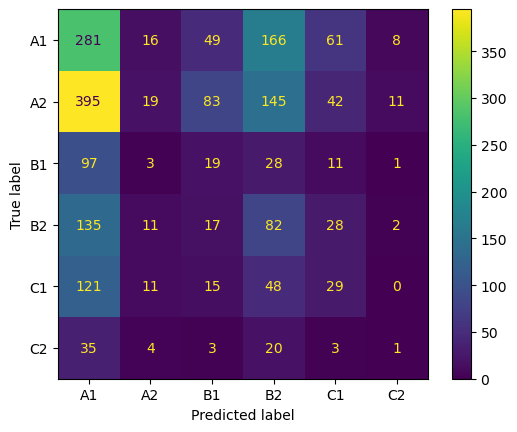

In [40]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

y_pred = test['predictions']

y_true = test['level']

def map_func(x):
    return label_to_id_mapping.get(x, -1)

y_true_mapped = np.vectorize(map_func)(y_true)
y_pred_mapped = np.vectorize(map_func)(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
print(f'Accuracy: {accuracy:.3f}')

# Generate accuracy report
unique_labels = set(y_true_mapped)  # Get unique labels

for label in unique_labels:
    label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
    label_y_true = [y_true_mapped[i] for i in label_indices]
    label_y_pred = [y_pred_mapped[i] for i in label_indices]
    label_accuracy = accuracy_score(label_y_true, label_y_pred)
    print(f'Accuracy for label {cefr_levels[label]}: {label_accuracy:.3f}')

class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))))
class_report_dict = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))), output_dict=True)
print('\nClassification Report:')
print(class_report)
table_data = []

for key, value in class_report_dict.items():
    if isinstance(value, dict):
        table_data.append([
            key,
            value.get("precision", 0),
            value.get("recall", 0),
            value.get("f1-score", 0),
            value.get("support", 0)
        ])
    else:
        # For accuracy, add precision and recall as 0
        table_data.append([
            key,
            0,
            0,
            value,
            class_report_dict["weighted avg"]["support"]
        ])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(cefr_levels))))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=cefr_levels)
disp.plot()


print('\nConfusion Matrix:')
print(conf_matrix)

wandb.log({
    "Class Proportions": wandb.sklearn.plot_class_proportions(train['level'], test['level'], cefr_levels),
    "Confusion Matrix": plt,
    "Classification Report": wandb.Table(data=table_data, columns=['Class/Metric', 'Precision', 'Recall', 'F1-score', 'Support'])
})

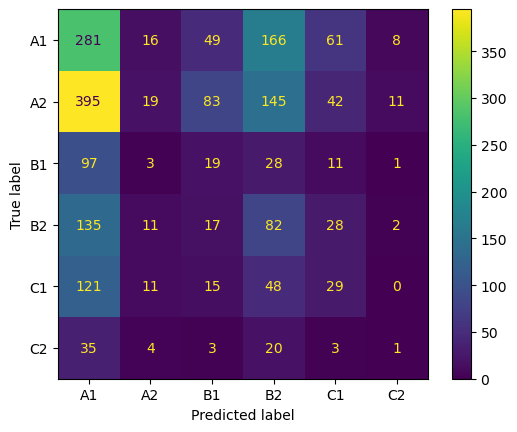

In [41]:
disp.plot()
plt.show()

In [42]:
print(f'Ended prediction at {datetime.datetime.now()}')
wandb.finish()

Ended prediction at 2024-08-15 00:40:59.321263
